Using device: cpu
Epoch 1/20: Loss=0.8413, Accuracy=0.9333
Epoch 2/20: Loss=0.1712, Accuracy=0.9167
Epoch 3/20: Loss=0.1891, Accuracy=0.9833
Epoch 4/20: Loss=0.0940, Accuracy=0.9333
Epoch 5/20: Loss=0.0340, Accuracy=0.9500
Epoch 6/20: Loss=0.0531, Accuracy=0.9833
Epoch 7/20: Loss=0.0108, Accuracy=0.9833
Epoch 8/20: Loss=0.0009, Accuracy=1.0000
Epoch 9/20: Loss=0.0037, Accuracy=0.9500
Epoch 10/20: Loss=0.1070, Accuracy=1.0000
Epoch 11/20: Loss=0.0412, Accuracy=1.0000
Epoch 12/20: Loss=0.0207, Accuracy=0.9667
Epoch 13/20: Loss=0.0014, Accuracy=0.9667
Epoch 14/20: Loss=0.0012, Accuracy=1.0000
Epoch 15/20: Loss=0.0022, Accuracy=0.9833
Epoch 16/20: Loss=0.0003, Accuracy=0.9667
Epoch 17/20: Loss=0.0014, Accuracy=1.0000
Epoch 18/20: Loss=0.0003, Accuracy=1.0000
Epoch 19/20: Loss=0.0001, Accuracy=1.0000
Epoch 20/20: Loss=0.0001, Accuracy=1.0000


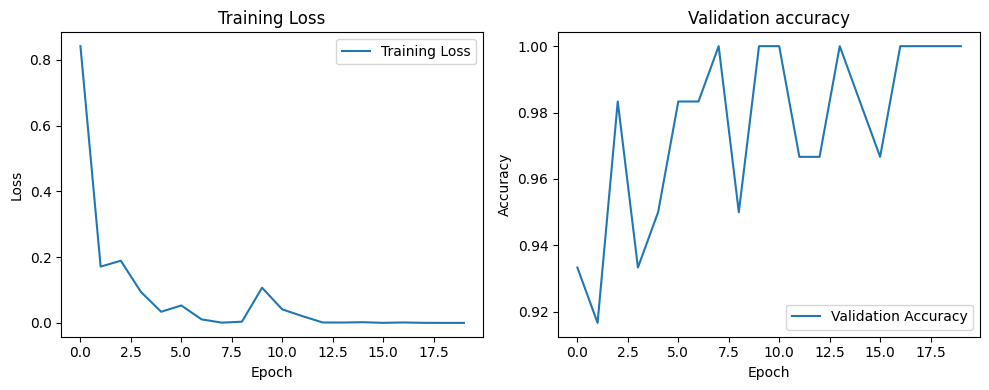

Classification Report:
               precision    recall  f1-score   support

     bladder       1.00      1.00      1.00        10
       bowel       1.00      1.00      1.00        10
 gallbladder       1.00      1.00      1.00        10
      kidney       1.00      1.00      1.00        10
       liver       1.00      1.00      1.00        10
      spleen       1.00      1.00      1.00        10

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



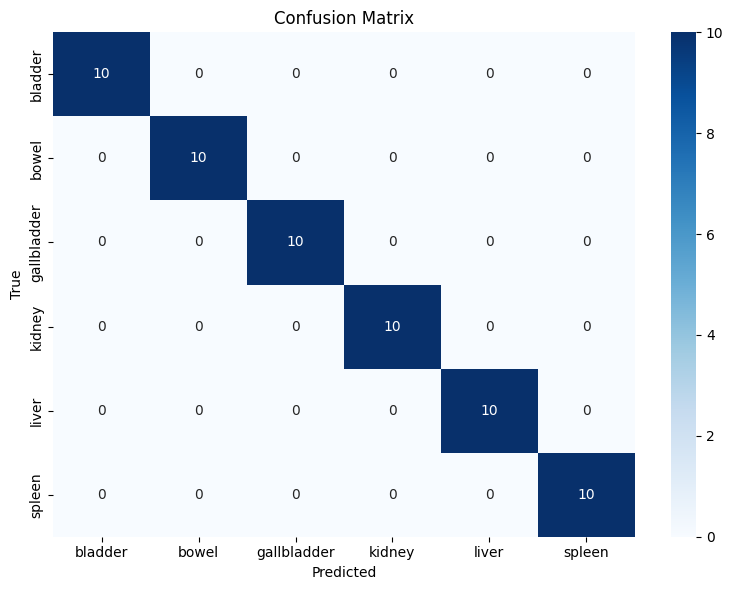

In [1]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

#paths
train_dir = r"C:\Users\Moritz\OneDrive\PC\Desktop\FH Kärnten\Master\2.Semester\DANN\dnn-project-ut\datasets\img\train"
test_dir = r"C:\Users\Moritz\OneDrive\PC\Desktop\FH Kärnten\Master\2.Semester\DANN\dnn-project-ut\datasets\img\test"
batch_size = 8
num_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#data preparation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}

#CNN model
class MiniVGGNet(nn.Module):
    def __init__(self, num_classes):
        super(MiniVGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

#train model
model = MiniVGGNet(num_classes=len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_hist = []
val_acc_hist = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_loss_hist.append(avg_loss)

    #accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    val_acc_hist.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.4f}, Accuracy={acc:.4f}")

#Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc_hist, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation accuracy")
plt.legend()
plt.tight_layout()
plt.show()


#Test Evaluation & Confusion Matrix
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=train_data.classes))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
